## Import

In [93]:
import torch

from PIL import Image
import numpy as np

from fastai.torch_core import set_seed

from diffusers import AutoencoderKL, UNet2DConditionModel, PNDMScheduler
from diffusers import UniPCMultistepScheduler

from transformers import CLIPTokenizer, CLIPTextModel

from tqdm.auto import tqdm

## Hyperparameter

In [4]:
epochs = 10
bs = 64
lr = 10e-3

## Device

In [12]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

## Data

## Pipeline

In [7]:
vae = AutoencoderKL.from_pretrained(
    "CompVis/stable-diffusion-v1-4", subfolder= "vae", use_safetensors= True)
tokenizer = CLIPTokenizer.from_pretrained(
    "CompVis/stable-diffusion-v1-4", subfolder= "tokenizer")
text_encoder = CLIPTextModel.from_pretrained(
    "CompVis/stable-diffusion-v1-4", subfolder= "text_encoder", use_safetensors= True)
unet = UNet2DConditionModel.from_pretrained(
    "CompVis/stable-diffusion-v1-4", subfolder= "unet", use_safetensors= True)

vae/config.json:   0%|          | 0.00/551 [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/335M [00:00<?, ?B/s]

tokenizer/tokenizer_config.json:   0%|          | 0.00/806 [00:00<?, ?B/s]

tokenizer/vocab.json:   0%|          | 0.00/1.06M [00:00<?, ?B/s]

tokenizer/merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

tokenizer/special_tokens_map.json:   0%|          | 0.00/472 [00:00<?, ?B/s]

text_encoder/config.json:   0%|          | 0.00/592 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/492M [00:00<?, ?B/s]

unet/config.json:   0%|          | 0.00/743 [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/3.44G [00:00<?, ?B/s]

In [9]:
scheduler = UniPCMultistepScheduler.from_pretrained(
    "CompVis/stable-diffusion-v1-4", subfolder= "scheduler")

scheduler/scheduler_config.json:   0%|          | 0.00/313 [00:00<?, ?B/s]

In [17]:
vae.to(device)
text_encoder.to(device)
unet.to(device)

device

'cuda'

### --------------------

### Text Embeddings

In [110]:
prompt = ["a photograph of an astronaut riding a horse"]
height = 512
width = 512
num_inference_steps = 25
guidance_scale = 7.5
generator = torch.cuda.manual_seed(42)
batch_size = len(prompt)

In [111]:
text_input = tokenizer(
    prompt, padding= "max_length", max_length= tokenizer.model_max_length, truncation= True, return_tensors= "pt")

with torch.no_grad():
    text_embeddings = text_encoder(text_input.input_ids.to(device))[0]

In [112]:
max_length = text_input.input_ids.shape[-1]
uncond_input = tokenizer(
    [""] * batch_size, padding= "max_length", max_length= max_length, return_tensors= "pt")
uncond_embeddings = text_encoder(uncond_input.input_ids.to(device))[0]

In [113]:
text_embeddings = torch.cat([uncond_embeddings, text_embeddings])

### --------------------

### Random Noise

In [114]:
latents = torch.randn(
    (batch_size, unet.config.in_channels, height // 8, width // 8),
    generator= generator,
    device= device)

### --------------------

### Denoise the Image

In [115]:
latents = latents * scheduler.init_noise_sigma

In [116]:
scheduler.set_timesteps(num_inference_steps)

for t in tqdm(scheduler.timesteps):

    latent_model_input = torch.cat([latents] * 2)

    latent_model_input = scheduler.scale_model_input(latent_model_input, timestep= t)

    with torch.no_grad():
        noise_pred = unet(latent_model_input, t, encoder_hidden_states= text_embeddings).sample

    noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
    noise_pred = noise_pred_uncond + guidance_scale * (noise_pred_text - noise_pred_uncond)

    latents = scheduler.step(noise_pred, t, latents).prev_sample

  0%|          | 0/25 [00:00<?, ?it/s]

### --------------------

### Decode the Image

In [117]:
latents = 1 / 0.18215 * latents
with torch.no_grad():
    image = vae.decode(latents).sample

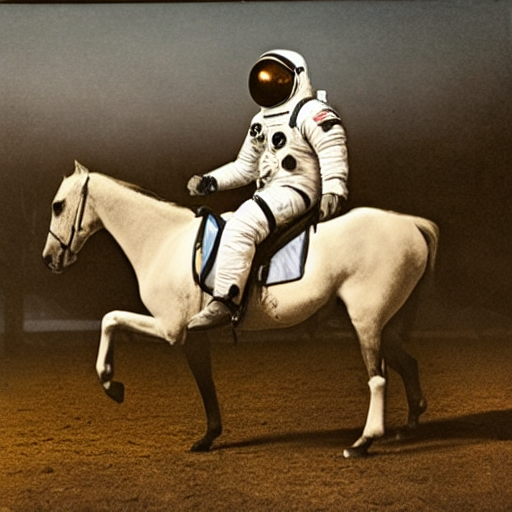

In [118]:
image = (image / 2 + 0.5).clamp(0, 1).squeeze()
image_np = (image.permute(1, 2, 0) * 255).round().to(torch.uint8).cpu().numpy()
image_np = Image.fromarray(image_np)
image_np

## Text-to-Image Generation